# 2-class classification neural network with a single hidden layer

Trong bài tập này, các bạn sẽ xây dựng một neural network với 1 hidden layer. Sau đó huấn luyện mạng này để phân biệt một bức ảnh có chứa mèo hay không.


## 1 - Packages ##

- [numpy](www.numpy.org) 
- [sklearn](http://scikit-learn.org/stable/)  
- [matplotlib](http://matplotlib.org)
- testCases dùng để sinh các dữ liệu nhỏ để kiểm tra các hàm có được cài đặt đúng chưa
- planar_utils dùng cho một số thao tác trong chương trình

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
#from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
#from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
!pip install testCases
%matplotlib inline

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement testCases (from versions: none)
ERROR: No matching distribution found for testCases


## 2 - Dataset ##

Trước tiên, hãy load dataset "flower". Đây là một dataset gồm các điểm xếp thành hình như một "flower" trên một mặt phẳng 2-D. Các điểm này thuộc 2 lớp đỏ (label y=0) và xanh (y=1). Mục tiêu của các bạn là xây dựng mô hình khớp với dữ liệu này.

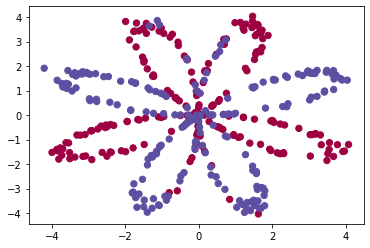

In [ ]:
X, Y = load_planar_dataset()

# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral);

Mô tả dữ liệu:
    - X là một numpy-array chứa các đặc trưng (x1, x2) của mỗi điểm
    - Y là một numpy-array chứa nhãn (red:0, blue:1).


Trước tiên ta cần xác định kích thước của dữ liệu.

In [ ]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))


The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!
400


## 3 - Thử phân loại dữ liệu này với logistic regression

Trước khi cài đặt Neural Network để phân loại dữ liệu này, ta sẽ thử làm với logistic regression sử dụng hàm trong sklearn.

In [ ]:
# Train the logistic regression classifier
#clf = sklearn.linear_model.LogisticRegressionCV();
#clf.fit(X.T, Y.T);
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, np.squeeze(Y.T));

Hãy xem độ chính xác của logistic regression là bao nhiêu.

In [ ]:
# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
'% ' + "(percentage of correctly labelled datapoints)")


Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)



Ta thấy độ chính xác của mô hình logistic regression rất thấp. Nguyên nhân là vì logistic regression là một mô hình phân loại tuyến tính. Nhìn vào dữ liệu "flower" ta thấy không thể vẽ một đường thẳng nào có thể tách biệt tốt 2 lớp xanh và đỏ.

Hãy xem đường phân loại tạo bởi logistic regression với dữ liệu "flower" này.


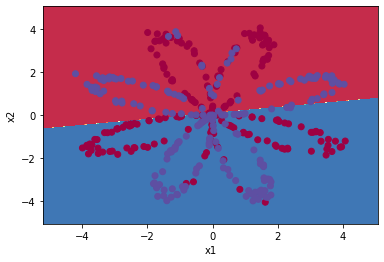

In [ ]:
# Plot the decision boundary for logistic regression

plot_decision_boundary(lambda x: clf.predict(x), X, np.squeeze(Y))



Có thể thấy các điểm xanh và đỏ không thể phân loại một cách tuyến tính. Ta hãy thử dùng Neural Network để xem kết quả thế nào.


## 4 - Mô hình Neural Network với 1 hidden layer

Mô hình Neural Network với 1 hidden layer.

<div>
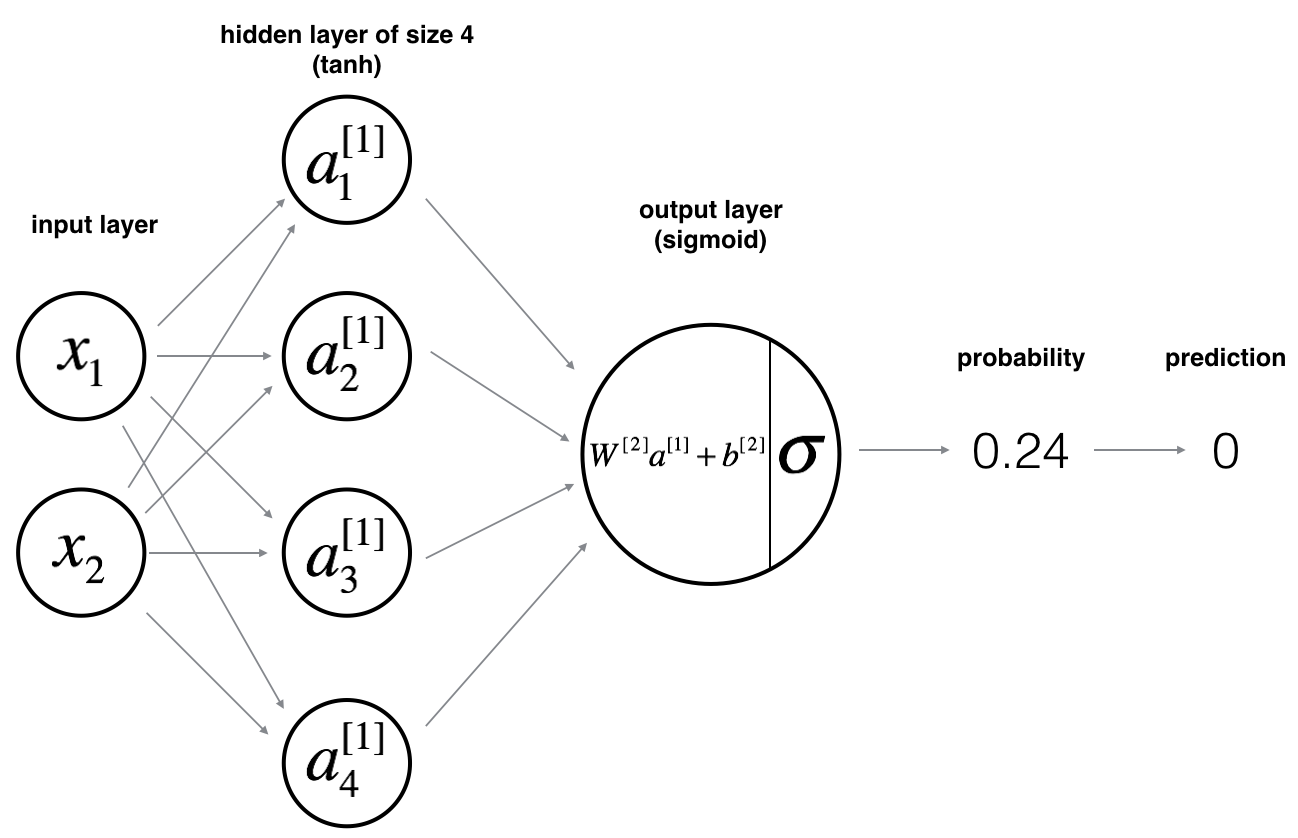
</div>

Mô hình toán:

Với một dữ liệu đầu vào (một điểm) $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Cost $J$ tính trên m dữ liệu đầu vào: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

Các bước để xây dựng mô hình:
    1. Xác định cấu trúc network ( số input, số hidden node,...). 
    2. Khởi tạo thông số w, b ở các layer
    3. Lặp:
        - Forward propagation
        - Tính Cost
        - Backward propagation to get the gradients
        - Update thông số w, b (dùng gradient descent)



### 4.1 - Xác định cấu trúc network ####

Bài tập 1: 

Định nghĩa 3 biến sau
    - n_0: the size of the input layer
    - n_1: the size of the hidden layer
    - n_2: the size of the output layer

Gợi ý: 

Mỗi dữ liệu đầu vào là một vector cột. Nhìn vào mô hình network ở trên, ta thấy kích thước input layer (layer 0) là số dòng của vector cột $x^{(i)}$. Ma trận đầu vào X là tập hợp của $m$ dữ liệu $x^{(i)}$ nên sẽ có số cột là $m$. 

Dữ liệu đầu ra Y trong trường hợp này (binary classification) chỉ là một vector hàng chứa $m$ xác suất ứng với $m$ dữ liệu trong X. Kích thước của output layer là số dòng của vector nhãn Y.

Như vậy 

n_0 = số dòng của ma trận X

n_1 là số node của hidden layer. Đây là một siêu tham số (hyperparameter) ta cần phải xác định khi xây dựng network.

n_2 là số dòng của vector hàng Y



In [ ]:
# FUNCTION: layer_sizes

def layer_sizes(X, Y, hidden_layer_size):

    ### START CODE HERE ###
    n_0 = X.shape[1]                  # size of input layer
    n_1 = hidden_layer_size
    n_2 = Y.shape[1]                    # size of output layer
    ### END CODE HERE ###
    return (n_0, n_1, n_2)

### 4.2 - Khởi tạo tham số w và b ####

Bài tập 2:

Các bạn cần cài đặt hàm `initialize_parameters()`.

Gợi ý:

Ma trận w1 và w2 cần phải được khởi tạo ngẫu nhiên và các giá trị cần phải nhỏ.
Vector cột b1 và b2 có thể được khởi tạo toàn zeros.

In [ ]:
# FUNCTION: initialize_parameters

def initialize_parameters(n_0, n_1, n_2):
    """
    Argument:
    n_0 -- size of the input layer
    n_1 -- size of the hidden layer
    n_2 -- size of the output layer
    
    Returns:
    parameters -- python dictionary chứa các tham số:
                    W1 -- weight matrix of shape (n_1, n_0)
                    b1 -- bias vector of shape (n_1, 1)
                    W2 -- weight matrix of shape (n_2, n_1)
                    b2 -- bias vector of shape (n_2, 1)
    """
    
    
    ### START CODE HERE ### 
    W1 = np.random.randn(n_1,n_0)*0.01
    b1 = np.zeros((n_1,1))
    W2 = np.random.randn(n_2,n_1)*0.01
    b2 = np.zeros((n_2,1))
    ### END CODE HERE ###
    

    
    assert (W1.shape == (n_1, n_0))
    assert (b1.shape == (n_1, 1))
    assert (W2.shape == (n_2, n_1))
    assert (b2.shape == (n_2, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    

    return parameters

In [ ]:
n_x, n_h, n_y = initialize_parameters_test_case()


parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

NameError: ignored

### 4.3 - The Loop ####

Bài tập 3:
Cài đặt hàm `forward_propagation()`.

Các bước thực hiện:

1. Lấy các tham số từ dictionary "parameters" (chính là output của hàm `initialize_parameters()`)

2. Cài đặt Forward Propagation. Tính $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ 

3. Chứa các biến mới thu được vào từ điển "`cache`". Ta sẽ dùng `cache` làm input cho hàm backpropagation.

In [ ]:
# FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    
    # Implement Forward Propagation 
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

Qua hàm forward_propagation, các bạn đã tính được $A^{[2]}$, các bạn tính hàm Cost như sau:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

Các bạn không cần phải tự cài đặt hàm này 🥳🥳🥳. Nhưng hãy chắc chắn hiểu được cách chuyển từ phương trình trên ra code. Phương trình trên có thể được cài đặt theo hai cách như các bạn có thể thấy ở dưới.


In [ ]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    
    Arguments:
    A2 -- Output của network
    Y -- Vector nhãn đúng
    parameters -- từ điển chứa W1, b1, W2 và b2
    
    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1] # số cột trong vector hàng Y (chính là số dữ liệu)

    # Tính cross-entropy cost
    # Cách 1
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = -np.sum(logprobs) / m
    
    # Cách 2    
    cost=-(np.dot(Y,np.log(A2).T)+np.dot((1-Y),np.log(1-A2).T))/m
    
    
    # makes sure cost is the dimension we expect (E.g., turns [[17]] into 17)
    cost = float(np.squeeze(cost))     
                                
    assert(isinstance(cost, float))
    
    return cost

Bài tập 4: 

Cài đặt hàm backward_propagation() theo các phương trình dưới đây.

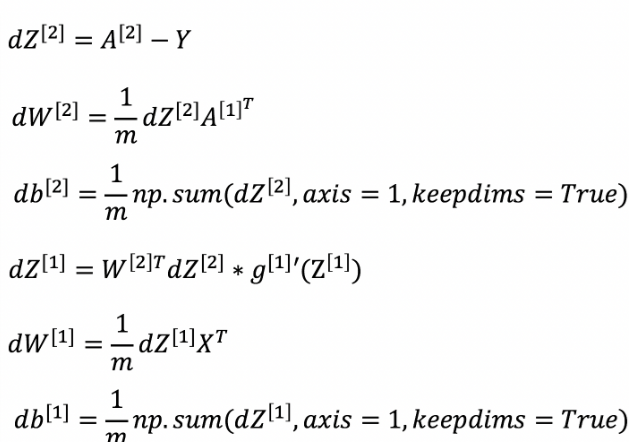



<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->


In [ ]:
# FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Cài đặt hàm backward propagation
    
    Arguments:
    parameters -- từ điển chứa các tham số W1, b1, W2, b2 
    cache -- từ điển chứa các giá trị "Z1", "A1", "Z2" and "A2".
    X -- input data kích thước (2, số lượng dữ liệu training)
    Y -- vector nhãn kích thước (1, số lượng dữ liệu training)
    
    Returns:
    grads -- python dictionary chứa các gradients
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".

    W1 = parameters["W1"]
    W2 = parameters["W2"]

        
    # Retrieve also A1 and A2 from dictionary "cache".

    A1 = cache["A1"]
    A2 = cache["A2"]

    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### 
    dZ2 = A2-Y
    dW2 = (1/m)*np.dot(dZ2,A1.T)
    db2 = 1/m*(np.sum(dZ2,axis=1, keepdims=True))
    dZ1 = np.multiply(np.dot(W2.T,dZ2),(1-np.power(A1,2)))
    dW1 = 1/m*(np.dot(dZ1,X.T))
    db1 = 1/m*(np.sum(dZ1,axis=1, keepdims=True))
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads


Bài tập 5: 

Cài đặt hàm update_parameters.

In [ ]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    Updates các tham số W1, b1, W2, b2
    
    Arguments:
    parameters -- từ điển chứa các tham số W1, b1, W2, b2
    grads -- từ điển chứa các gradients dW1, db1, dW2, db2
    
    Returns:
    parameters -- từ điển chứa các tham số W1, b1, W2, b2 sau khi được update
    """
    # Lấy ra các tham số khỏi từ điển "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    
    # lấy các gradients khỏi từ điển grads
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    
    # Update 
    ### START CODE HERE ###
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 4.4 - Lắp ghép các thành phần ở trên thành mô hình ####


In [ ]:
# FUNCTION: nn_model

def nn_model(X, Y, hidden_layer_size , num_iterations, learning_rate, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """


    n_0 = layer_sizes(X, Y, hidden_layer_size)[0]
    n_1 = layer_sizes(X, Y, hidden_layer_size)[1]
    n_2 = layer_sizes(X, Y, hidden_layer_size)[2]
    

    parameters = initialize_parameters(n_0,n_1,n_2)
   
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
        
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X,parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2,Y,parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters,cache,X,Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters,grads,learning_rate)
        
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [ ]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, 10000, 1.2, print_cost=False)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

NameError: ignored

**Expected Output**:

<table style="width:90%">



  <tr>
    <td>**W1**</td>
    <td> [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-2.45566237 -3.27042274  2.00784958  3.36773273]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.20459656]] </td> 
  </tr>
  
</table>  

### 4.5 Predictions

Sử dụng mô hình để dự đoán nhãn của dữ liệu input. Ta sẽ dùng hàm foward_propagation để tính output activation A2. 

predictions = $y_{prediction} = \begin{cases} 1 \ \text{if}\ A2 > 0.5 \\ 0  \ \text{otherwise} \end{cases}$


    
    


In [ ]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Hàm sử dụng các tham số đã được huấn luyện W và b chứa trong từ điển parameters để dự đoán nhãn của X
    
    Arguments:
    parameters -- python dictionary chứa các tham số W, b
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector hàng kích thước (1,m) chứa nhãn của m dữ liệu trong X (red: 0 / blue: 1)
    """
    
    # Tính output A2 sử dụng hàm forward propagation
    A2, cache = forward_propagation(X,parameters)
    
    # Đổi A2 (là xác suất dữ liệu thuộc lớp nào) sang nhãn 0 hoặc 1
    predictions = 1*(A2>0.5)
    
    
    return predictions

## 5 - Chạy thử mô hình với dữ liệu "flower"##

Như vậy ta đã hoàn thành mọi thành phần của mô hình. Hãy chạy thử mô hình với dữ liệu "flower" xem kết quả thế nào.

### 5.1 Thử với hidden layer có 4 node ### 

In [ ]:
# Thử với hidden layer có 4 node
hidden_layer_size = 4

num_iterations = 10000
learning_rate = 1.2

# Xây dựng model
parameters = nn_model(X, Y, 4, num_iterations, learning_rate, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
plt.title("Decision Boundary for hidden layer size " + str(4))

ValueError: ignored

In [ ]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

NameError: ignored

**Expected Output**: 

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td> 
  </tr>
</table>

Ta thấy độ chính xác cao hơn nhiều so với Logistic Regression. Lý do cho điều này là Neural Network có thể học được những đường phân loại phi tuyến (không như Logistic regression chỉ có thể học phân loại tuyến tính).




### 5.2 - Thử với hidden layer kích thước khác nhau ###



In [ ]:
# This may take about 2 minutes to run

num_iterations = 10000
learning_rate = 1.2

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations, learning_rate)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))
    


Ta thấy mô hình lớn hơn (số node trong hidden layer nhiều hơn) có thể fit với tập train tốt hơn. Nhưng khi mô hình lớn quá thì dẫn đến overfit, tức là mô hình có thể học luôn những nhãn bị dán sai. (Các bạn sẽ học được cách tránh overfitting bằng cách sử dụng regularization ở các bài sau).

### 5.3 - Thử với dữ liệu ảnh###

Qua bộ dữ liệu "flower", ta thấy được khả năng phân loại phi tuyến của Neural Network so với logistic regession. Hãy quay lại bộ dữ liệu ảnh 🐱 và dùng Neural Network với cùng thông số như trên để xem kết quả phân loại thế nào.

In [ ]:
import h5py
def load_dataset():
    train_dataset = h5py.File('Deeplearning/datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
    test_dataset = h5py.File('Deeplearning/datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()



train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten =  test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T


train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.


hidden_layer_size = 4
num_iterations = 10000
learning_rate = 1.2

parameters = nn_model(train_set_x, train_set_y, hidden_layer_size, num_iterations, learning_rate, print_cost=True)



# Print accuracy on train_set
predictions = predict(parameters, train_set_x)
print ('Train accuracy: %d' % float((np.dot(train_set_y,predictions.T) + np.dot(1-train_set_y,1-predictions.T))/float(train_set_y.size)*100) + '%')

# Print accuracy on test_set
predictions = predict(parameters, test_set_x)
print ('Test accuracy: %d' % float((np.dot(test_set_y,predictions.T) + np.dot(1-test_set_y,1-predictions.T))/float(test_set_y.size)*100) + '%')



Bài tập 6:

Hãy thử set lại thông số cho mô hình Neural Network với kích thước hidden layer là 7, số lần lặp là 2500, và learning_rate là 0.005. Do các tham số được set ngẫu nhiên nên mỗi lần chạy sẽ cho ra kết quả khác nhau. Hãy report lại Test accuracy cao nhất mà bạn chạy ra được với mô hình này. 

Có thể bạn phải chạy thử nhiều lần để ra được kết quả trên 80% nhé 😹.


In [ ]:
hidden_layer_size = 7
num_iterations = 2500
learning_rate = 0.05

### START CODE HERE ###